In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.layers import Dense,Dropout,Flatten,AveragePooling2D,Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers.legacy import Adam
from imutils import paths
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse

In [2]:
INIT_LR=1e-4
EPOCHS=20
BS=32

In [3]:
print(list(paths.list_images('dataset')))
imagePaths = list(paths.list_images('dataset'))
data=[]
labels=[]

for image_path in imagePaths:
    label = image_path.split(os.path.sep)[-2]
    image = load_img(image_path,target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

['dataset\\without_mask\\0.jpg', 'dataset\\without_mask\\0_0_aidai_0014.jpg', 'dataset\\without_mask\\0_0_aidai_0029.jpg', 'dataset\\without_mask\\0_0_aidai_0043.jpg', 'dataset\\without_mask\\0_0_aidai_0074.jpg', 'dataset\\without_mask\\0_0_aidai_0084.jpg', 'dataset\\without_mask\\0_0_aidai_0136.jpg', 'dataset\\without_mask\\0_0_anhu_0004.jpg', 'dataset\\without_mask\\0_0_anhu_0020.jpg', 'dataset\\without_mask\\0_0_anhu_0025.jpg', 'dataset\\without_mask\\0_0_anhu_0027.jpg', 'dataset\\without_mask\\0_0_anhu_0056.jpg', 'dataset\\without_mask\\0_0_anhu_0057.jpg', 'dataset\\without_mask\\0_0_anhu_0062.jpg', 'dataset\\without_mask\\0_0_anhu_0063.jpg', 'dataset\\without_mask\\0_0_anhu_0098.jpg', 'dataset\\without_mask\\0_0_anhu_0103.jpg', 'dataset\\without_mask\\0_0_anhu_0155.jpg', 'dataset\\without_mask\\0_0_anhu_0157.jpg', 'dataset\\without_mask\\0_0_anhu_0189.jpg', 'dataset\\without_mask\\0_0_anhu_0201.jpg', 'dataset\\without_mask\\0_0_anhu_0205.jpg', 'dataset\\without_mask\\0_0_anhu_0209

C:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
labels = np.array(labels)
data = np.array(data,dtype='float32')

In [5]:
labels

array(['without_mask', 'without_mask', 'without_mask', ..., 'with_mask',
       'with_mask', 'with_mask'], dtype='<U12')

In [6]:
lb = LabelBinarizer()
labels_lb=lb.fit_transform(labels)
labels_lb

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [7]:
labels = to_categorical(labels_lb)
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.20,random_state=324)

In [9]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
import gc
del data
del labels
gc.collect

<function gc.collect(generation=2)>

In [11]:
baseModel = MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation='softmax')(headModel)

In [13]:
model = Model(inputs = baseModel.input,outputs = headModel)

In [14]:
for layer in baseModel.layers:
    layer.trainable = False

In [15]:
opt = Adam(learning_rate=INIT_LR,decay=INIT_LR/EPOCHS)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
model.fit(
    aug.flow(X_train,y_train,batch_size=BS),
    steps_per_epoch=len(X_train)//BS,
    epochs=EPOCHS,
    validation_data=(X_test,y_test),
    validation_steps=len(X_test)//BS
)

Epoch 1/20
102/102 [==============================] - 116s 1s/step - loss: 0.3246 - accuracy: 0.8544 - val_loss: 0.1203 - val_accuracy: 0.9621
Epoch 2/20
102/102 [==============================] - 109s 1s/step - loss: 0.1196 - accuracy: 0.9550 - val_loss: 0.0804 - val_accuracy: 0.9780
Epoch 3/20
102/102 [==============================] - 118s 1s/step - loss: 0.0805 - accuracy: 0.9719 - val_loss: 0.0683 - val_accuracy: 0.9805
Epoch 4/20
102/102 [==============================] - 155s 2s/step - loss: 0.0670 - accuracy: 0.9766 - val_loss: 0.0637 - val_accuracy: 0.9817
Epoch 5/20
102/102 [==============================] - 153s 1s/step - loss: 0.0615 - accuracy: 0.9787 - val_loss: 0.0658 - val_accuracy: 0.9792
Epoch 6/20
102/102 [==============================] - 155s 2s/step - loss: 0.0498 - accuracy: 0.9830 - val_loss: 0.0553 - val_accuracy: 0.9866
Epoch 7/20
102/102 [==============================] - 153s 2s/step - loss: 0.0538 - accuracy: 0.9824 - val_loss: 0.0502 - val_accuracy: 0.9890

In [17]:
model.save('trained_model.h5',save_format='h5')

C:\Users\MILAD-CO\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# --------------------reset kernel

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import cv2
import os
import numpy as np

In [2]:
params = {
   'scalefactor': 1.0,
   'size': (224, 224),
   'mean': (104.0, 177.0, 123.0)
}

In [21]:
prototxtPath = os.path.sep.join(['face_detector', "deploy.prototxt"])
weightsPath = os.path.sep.join(['face_detector',"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath,weightsPath)
model = load_model('trained_model.h5')
image = cv2.imread('dataset/with_mask/0999.png')
orig = image.copy()
print(image.shape)
(h,w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image,**params)
net.setInput(blob)
detections = net.forward()
print(detections.shape)

(591, 692, 3)
(1, 1, 200, 7)


In [22]:
for i in range(detections.shape[2]):
    confidence = detections[0,0,i,2]
    if confidence>0.6:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        face = image[startY:endY,startX:endX]
#         face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        face = cv2.resize(face,(224,224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face,axis=0)
        (mask,without_mask) = model.predict(face)[0]
        label = 'Mask' if mask>without_mask else 'No Mask'
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = '{}:{}'.format(label,max(mask,without_mask)*100)
        cv2.putText(image,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)

1/1 [==============================] - 1s 1s/step


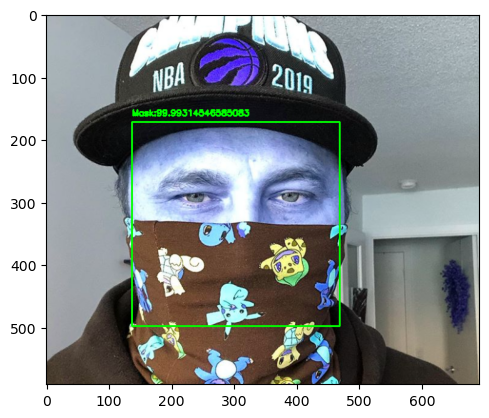

In [23]:
import matplotlib.pyplot as plt
plt.imshow(image)